In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# %matplotlib inline
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 7.5)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'Times New Roman'

  # Computational Statistics Homework 08

  Kalin Gibbons  
  2020-03-31


 ## Problem 1: Implementing Example 6.3 on page 157 of _Computational Statistics_
 
 ---

 Reproduce FIGURE 6.7


In [3]:
init_sample = int(100e3)
sample_sz = int(5e3)


def normal_pdf(x):
    """Calculate standard normal probability density.

    Args:
        x (float): The realized random normal variable.

    Returns:
        float: Probability density of the realized random normal variable.

    """
    return stats.norm().pdf(x)


def slash_pdf(x):
    """Calculate slash probability density.

    Args:
        x (float): The realized random variable.

    Returns:
        float: Probability density of the realized random variable.

    """
    is_zero = (x == 0)
    num = 1 - np.exp(-x ** 2 / 2)
    den = x ** 2 * np.sqrt(2 * np.pi)
    den[is_zero] = 1
    density = num / den
    density[is_zero] = 1 / (2 * np.sqrt(2 * np.pi))
    return density


def sample_normal(size=1):
    """Wrap stats.norm.rvs() method to allow same syntax as sample_slash.

    Args:
        size (int, optional): Size of the sample. Defaults to 1.

    Returns:
        float: the realized normal random variables. An array of length `size`.

    """
    return stats.norm.rvs(size=size)


def sample_slash(size=1):
    """Sample from the slash distribution.

    Args:
        size (int, optional): Size of the sample to be drawn. Defaults to 1.

    Returns:
        float: the realized slash random variables. An array of length `size`.

    """
    u = stats.uniform.rvs(size=size)
    z = stats.norm.rvs(size=size)
    return z / u


def calc_weights(y, target):
    """Calculate the resampling weights for example 6.3.

    Args:
        y (float): Samples from the proposed distribution.
        target (string): Either 'normal' or 'slash', to designate which
        distribution is the target.

    Returns:
        float: An array of weightings used for resampling.

    """
    assert target.lower() in ('normal', 'slash'), 'Unrecognized target.'
    if target.lower() == 'slash':
        num = slash_pdf(y) / normal_pdf(y)
    elif target.lower() == 'normal':
        num = normal_pdf(y) / slash_pdf(y)

    return num / num.sum()


def resample(y, weights, size=1):
    """Resample the proposed distribution samples with weights.

    Args:
        y (float): The original sample from the proposed distribution.
        weights (float): An array of weightings for each sampled point.
        size (int, optional): The size of the target sample. Defaults to 1.

    Returns:
        float: The resampled values, which will match the target distribution.

    """
    return np.random.choice(y, size=size, replace=True, p=weights)


def importance_resampling(size, init_size, target='slash'):
    """Perform sampling-importance-resampling algorithm in Example 6.3.

    Args:
        size (int): The target sample size.
        init_size (int): The size of the initial sampling. Should be at least
        ten times larger than size.
        target (str, optional): Specify the target distribution as 'normal' or
        'slash'. Defaults to 'slash'.

    Returns:
        float: An array of samples from the target distribution.

    """
    assert target.lower() in ('normal', 'slash'), 'Unrecognized target.'
    if target.lower() == 'slash':
        y = sample_normal(size=init_size)
    elif target.lower() == 'normal':
        y = sample_slash(size=init_size)

    w = calc_weights(y, target=target)
    x = resample(y, weights=w, size=size)
    return x

 To ensure the figure is the same every time the script is run, we can seed
 the random number generator with an integer that causes a large number of
 draws in the left edge of the slash distributions tails.

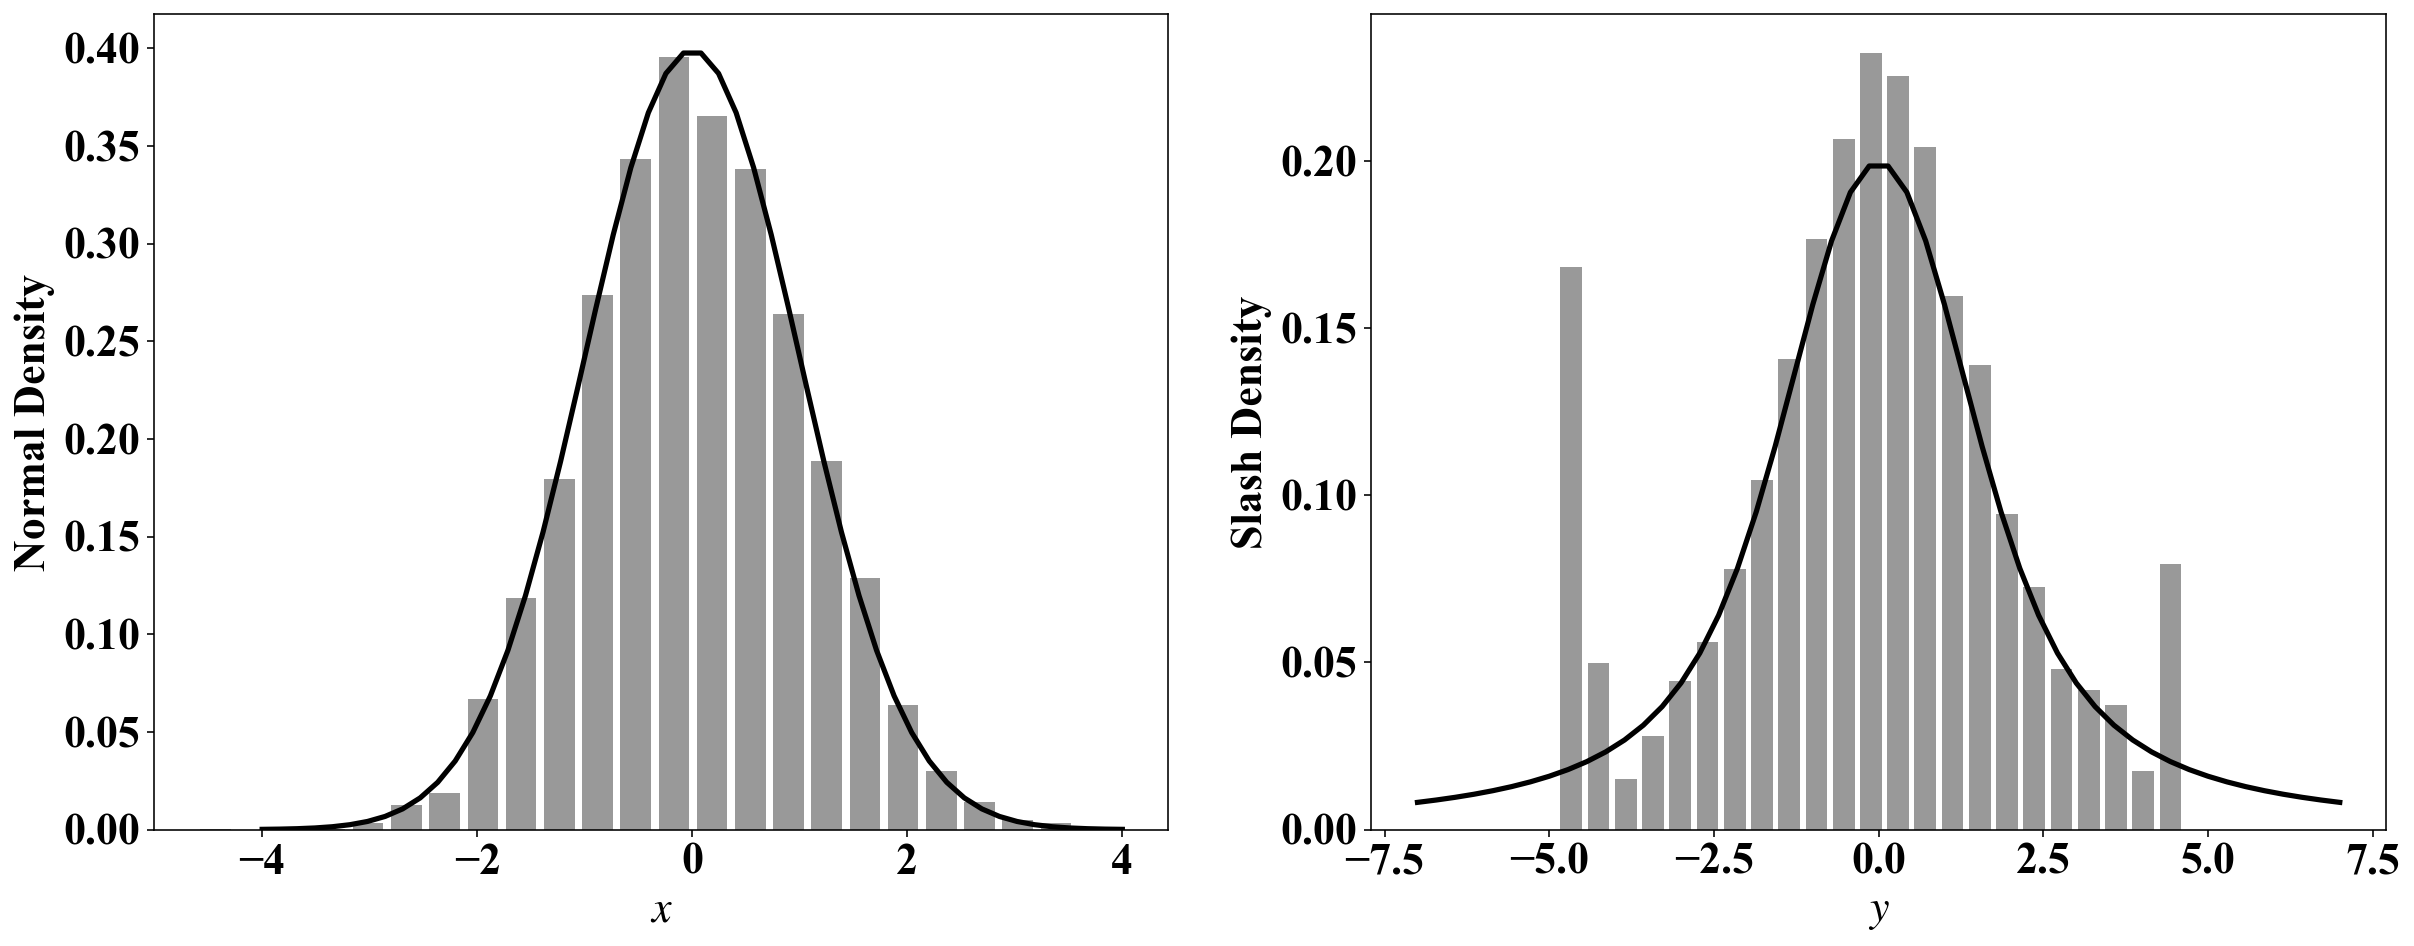

In [4]:
np.random.seed(17)  # consistent_region
n_bins = 23
x = importance_resampling(sample_sz, init_sample, target='normal')
fig_sz = np.array((20, 7.5)) * 1.00
plt.figure(figsize=fig_sz)
plt.subplot(1, 2, 1)
plt.hist(x, bins=n_bins, density=True, color='0.6', rwidth=0.8)
norm_dom = np.linspace(-4, 4)
plt.plot(norm_dom, normal_pdf(norm_dom), 'k', linewidth=2.6)
plt.xlabel(r'$x$')
plt.ylabel('Normal Density')

y = importance_resampling(sample_sz, init_sample, target='slash')
plt.subplot(1, 2, 2)
plt.hist(y, bins=n_bins, density=True, color='0.6', rwidth=0.8)
slash_dom = np.linspace(-7, 7)
plt.plot(slash_dom, slash_pdf(slash_dom), 'k', linewidth=2.6)
plt.xlabel(r'$y$')
plt.ylabel('Slash Density')

plt.show()
np.random.seed(None)  # end_consistent_region

 This looks very similar to Figure 6.7 in _Computational Statistics_, and we
 can see that the point when the weights when the target is the slash
 distribution (right), tends to infinity is around $\pm5$, as stated in the
 example.

 <br/>
 <br/>

 ## Problem 2: Implementing the SIR algorithm - Bayesian Statistics
 
 ---

 Implementing the SIR algorithm in Example 6.4 on page 166 for the case of
 Example 6.2, report your estimated posterior mean and posterior standard
 deviation. Show the generated random samples by superimposing the following
 three items in a single plot:

 1. a relative frequency histogram with an appropriate number of bars for your
    generated random numbers with sample size $n = 5000$

 2. an estimated probability density curve based on the generated random
    numbers

 3. the true posterior probability density curve

 > __NOTE__: you must use different line types for each curve, and use a
 > legend.

<br/>
<br/>

### Solution

For Bayesian problems, our target distribution is the posterior $f(\theta|x)$,
and we perform SIR by

  1. sampling from the prior distribution $f(\theta)$

  2. calculating weights based on the likelihood $L(x | \theta)$ or
     $L(\theta | x)$, depending on the source

  3. resampling from the discrete sample of the prior using the weights as
     our probability masses

So, we can start by defining functions for calculating the likelihood and the
weights, as well as the true posterior density function, which is our target.

In [5]:
def likelihood(lambda_, x):
    """Calculate the likelihood function.

    Args:
        lambda_ (float): The shape parameter of the Poisson distribution
        x (int): An array of observed data values

    Returns:
        float: The likelihood that the observed data came from a Poisson
        distribution with shape parameter lambda_.

    """
    numerator = lambda_ ** x * np.exp(-lambda_)
    denominator = scipy.special.factorial(x)
    return (numerator / denominator).prod()


def calc_weights(lambda_, x):
    """Calculate the probability mass for resampling.

    Args:
        lambda_ (float): An array of proposed Poisson distribution shape
        parameters.
        x (int): An array of observed data values

    Returns:
        float: An array of probability masses proportional to the likelihood.

    """
    like = np.full_like(lambda_, np.nan)
    for idx, lam in enumerate(lambda_):
        like[idx] = likelihood(lam, x)
    weights = like / like.sum()
    return weights


def target_pdf(lambda_, x):
    """Evaluate the posterior probability density.

    Args:
        lambda_ (float): An array of Poisson distribution shape parameters.
        x (int): An array of observed data.

    Returns:
        float: The probability density that a Poisson distribution with shape
        parameter lambda_ explains the observed data x.

    """
    unnormalized_dense = np.full_like(lambda_, np.nan)
    for idx, lam in enumerate(lambda_):
        unnormalized_dense[idx] = prior_rv.pdf(lam) * likelihood(lam, x)

    margin_data_dense = scipy.integrate.simps(unnormalized_dense, lambda_)
    density = unnormalized_dense / margin_data_dense
    return density

In [6]:
# Define the problem
target_sz = int(5e3)
proposed_sz = 10 * target_sz
observations = np.array([8, 3, 4, 3, 1, 7, 2, 6, 2, 7])
prior_rv = stats.lognorm(s=0.5, scale=np.exp(np.log(4)))

# Sampling Importance Resampling
lambda_ = prior_rv.rvs(size=proposed_sz)
weights = calc_weights(lambda_=lambda_, x=observations)
posterior_lambda = resample(y=lambda_, weights=weights, size=target_sz)

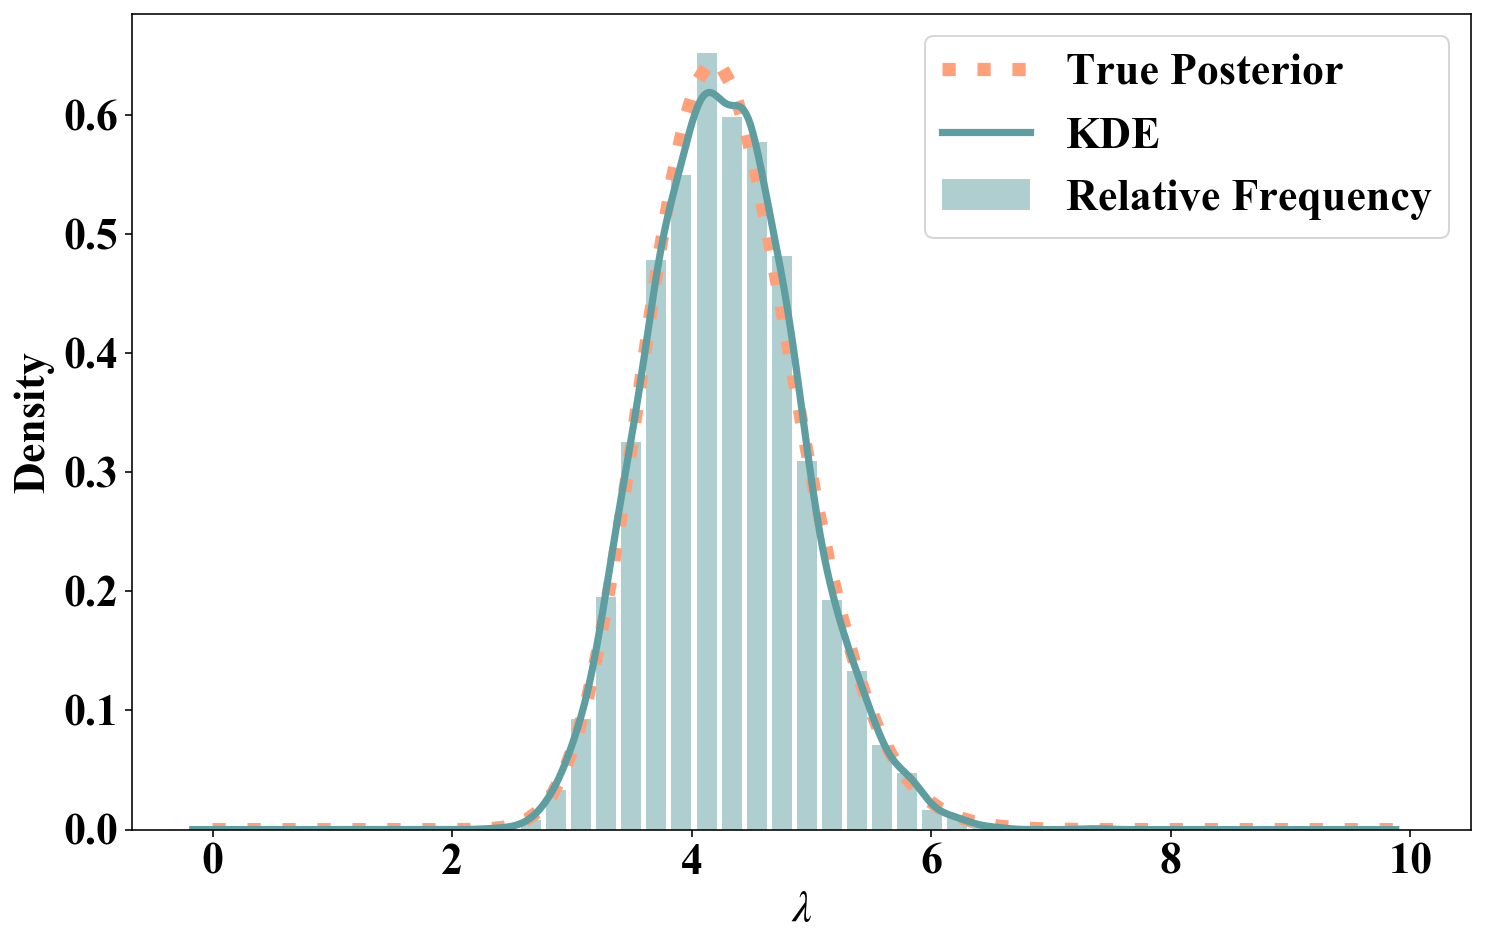

The posterior sample mean is 4.2739
The posterior sample standard deviation is 0.6164


In [7]:
# Create the output.
plt.figure()
posterior_lambda = pd.Series(posterior_lambda)
plt.hist(posterior_lambda, bins=24, rwidth=0.8, color='CadetBlue', alpha=0.5,
         density=True, label='Relative Frequency')
dom = np.linspace(0, 10, 100)
true_density = target_pdf(dom, x=observations)
plt.plot(dom, true_density, ':', color='LightSalmon', linewidth=6.6,
         label='True Posterior')
posterior_lambda.plot.kde(label='KDE', linewidth=3.6, color='CadetBlue')
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel('Density')
plt.show()

print(f'The posterior sample mean is {posterior_lambda.mean():.4f}')
print(
    f'The posterior sample standard deviation is {posterior_lambda.std():.4f}'
)

 That plot makes sense, and the mean is matching the sample mean of 4.3, which
 Example 6.2 stated would maximize the likelihood function.